## 放款数据总结与违约分析

- **第一部分：放款数据总结**：汇总表（指标/数值）、贷款状态分布，按信用等级/用途/收入核验等维度的笔数、放款总金额、平均放款金额、违约率
- **第二部分：违约分析**：按等级、利率分箱、DTI 分箱、循环使用率分箱、近两年逾期次数、破产记录等维度的违约率

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "loan_clean.csv", low_memory=False) #把清洗后的数据存为了loan_clean.csv的新文件

# 违约标记：Charged Off、Default、Late、In Grace Period
BAD_STATUS = ["Charged Off", "Default", "Late (31-120 days)", "Late (16-30 days)", "In Grace Period"]
df["is_default"] = df["loan_status"].isin(BAD_STATUS).astype(int)

print("Shape:", df.shape)
print("Overall default rate:", f"{df['is_default'].mean():.2%}")
df[["loan_status", "is_default", "funded_amnt", "grade"]].head()

Shape: (167981, 52)
Overall default rate: 1.18%


,loan_status,is_default,funded_amnt,grade
0,Current,0,2500,C
1,Current,0,30000,D
2,Current,0,5000,D
3,Current,0,4000,D
4,Current,0,30000,C


**数据概览（表格总结）**  
- 样本量：约 **16.8 万** 条已放款记录，**52** 个特征。  
- 整体违约率：**1.18%**（将 Charged Off / Default / Late / In Grace Period 视为违约）。  
- 为后续放款数据总结与违约分析提供统一口径的违约标签与基础字段。

### 第一部分：总结放款数据

汇总表（指标 / 数值）、贷款状态条形图（笔数 / loan_status），以及按维度的拆分：笔数、放款总金额、平均放款金额、违约率（均为英文列名）。

In [3]:
# 汇总表（英文列名）
struct = pd.DataFrame({
    "Metric": ["Loan count", "Total funded amount", "Average funded amount"],
    "Value": [len(df), df["funded_amnt"].sum(), df["funded_amnt"].mean().round(0)],
})
print("Structure (funded loans)")
display(struct)

Structure (funded loans)


,Metric,Value
0,Loan count,1.679810e+05
1,Total funded amount,2.741648e+09
2,Average funded amount,1.632100e+04


**Structure 表总结**  
- **Loan count**：约 16.8 万笔；**Total funded amount**：约 27.4 亿美元；**Average funded amount**：约 1.63 万美元/笔。  
- 用于建立放款规模与笔均金额的基准，便于后续按维度对比。

In [4]:
def struct_by_dim(df, dim):  #相当于做了一个按dim分组的数据透视表
    if dim not in df.columns:
        return None
    g = df.groupby(dim).agg(
        Count=("funded_amnt", "count"), #即count是按dim分组后，funded_amnt的计数
        Total_Funded_Amount=("funded_amnt", "sum"), #即Total_Funded_Amount是按dim分组后，funded_amnt的求和
    ).reset_index() #reset_index() 是将分组后的结果转换为 DataFrame 格式，并重置索引。否则，无法进行后续的合并操作。
    g["Avg_Funded_Amount"] = (g["Total_Funded_Amount"] / g["Count"]).round(0)
    if "is_default" in df.columns:
        def_rate = df.groupby(dim)["is_default"].mean().reset_index()

        def_rate = def_rate.rename(columns={"is_default": "Default_Rate"})
        g = g.merge(def_rate, on=dim)
        g["Default_Rate"] = g["Default_Rate"].round(4)
    return g

by_grade = struct_by_dim(df, "grade") #就是用上面定义的函数，按grade分组
print("By grade")
display(by_grade)

By grade


,grade,Count,Total_Funded_Amount,Avg_Funded_Amount,Default_Rate
0,A,50701,822215725,16217.0,0.0040
1,B,46403,775797250,16719.0,0.0083
2,C,40330,660206300,16370.0,0.0146
3,D,22433,362028625,16138.0,0.0234
4,E,7077,102929200,14544.0,0.0295
5,F,856,15221725,17782.0,0.0619
6,G,181,3249450,17953.0,0.0718


**By grade 表总结**  
- 笔数：A 最多（约 5.1 万），随等级恶化递减，G 仅约 181 笔。  
- 违约率随等级单调上升：A 0.40% → B 0.83% → C 1.46% → D 2.34% → E 2.95% → F 6.19% → G 7.18%。  
- **结论**：等级与违约率强相关，可用于客群分层与定价/准入。

In [5]:
by_purpose = struct_by_dim(df, "purpose") #就是用上面定义的函数，按purpose分组
by_purpose = by_purpose.sort_values("Count", ascending=False).head(10) #按by_purpose的Count列降序排序，并取前10行
print("By purpose (Top 10)")
display(by_purpose)
by_purpose_dr=by_purpose.sort_values("Default_Rate", ascending=False).head(10)
print("By purpose (Top 10) with Default Rate")
display(by_purpose_dr)

By purpose (Top 10)


,purpose,Count,Total_Funded_Amount,Avg_Funded_Amount,Default_Rate
2,debt_consolidation,92690,1628185450,17566.0,0.0122
1,credit_card,46798,747100525,15964.0,0.0084
3,home_improvement,9725,148646225,15285.0,0.0145
8,other,8671,96106775,11084.0,0.0176
5,major_purchase,2952,39075850,13237.0,0.0166
6,medical,1743,16762275,9617.0,0.0178
0,car,1362,13941775,10236.0,0.0117
10,small_business,1035,19246825,18596.0,0.0155
11,vacation,1023,6607400,6459.0,0.0108
4,house,978,15773175,16128.0,0.0164


By purpose (Top 10) with Default Rate


,purpose,Count,Total_Funded_Amount,Avg_Funded_Amount,Default_Rate
6,medical,1743,16762275,9617.0,0.0178
8,other,8671,96106775,11084.0,0.0176
5,major_purchase,2952,39075850,13237.0,0.0166
4,house,978,15773175,16128.0,0.0164
10,small_business,1035,19246825,18596.0,0.0155
3,home_improvement,9725,148646225,15285.0,0.0145
2,debt_consolidation,92690,1628185450,17566.0,0.0122
0,car,1362,13941775,10236.0,0.0117
11,vacation,1023,6607400,6459.0,0.0108
1,credit_card,46798,747100525,15964.0,0.0084


**By purpose (Top 10) 表总结**  
- **debt_consolidation**、**credit_card** 占主导（约 9.3 万、4.7 万笔），合计超八成。  
- 违约率：credit_card 较低（0.84%），debt_consolidation 约 1.22%，other / medical 等略高（约 1.5%–1.8%）。  
- **结论**：用途集中，风险差异明显，可针对高违约用途做额度或定价区分。

In [ ]:
by_ver = struct_by_dim(df, "verification_status")
print("By verification_status")
display(by_ver)


By verification_status


,verification_status,Count,Total_Funded_Amount,Avg_Funded_Amount,Default_Rate
0,Not Verified,69266,955510975,13795.0,0.0087
1,Source Verified,70794,1222734500,17272.0,0.0125
2,Verified,27921,563402800,20178.0,0.0176


**By verification_status 表总结**  
- 笔数：Not Verified 约 6.9 万、Source Verified 约 7.1 万、Verified 约 2.8 万，分布较均衡。  
- 违约率：Not Verified 最低（0.87%），Source Verified 1.25%，Verified 最高（1.76%）；可能与高额/高风险客户更常被要求核验有关。（可能因为高风险或大额借贷都需要被核实，而这些贷款往往有较大概率违约）
- **结论**：核验状态与违约率非单调，需结合金额与等级一起看，用于反欺诈与流程优化。

In [24]:
by_grade

,grade,Count,Total_Funded_Amount,Avg_Funded_Amount,Default_Rate
0,A,50701,822215725,16217.0,0.0040
1,B,46403,775797250,16719.0,0.0083
2,C,40330,660206300,16370.0,0.0146
3,D,22433,362028625,16138.0,0.0234
4,E,7077,102929200,14544.0,0.0295
5,F,856,15221725,17782.0,0.0619
6,G,181,3249450,17953.0,0.0718


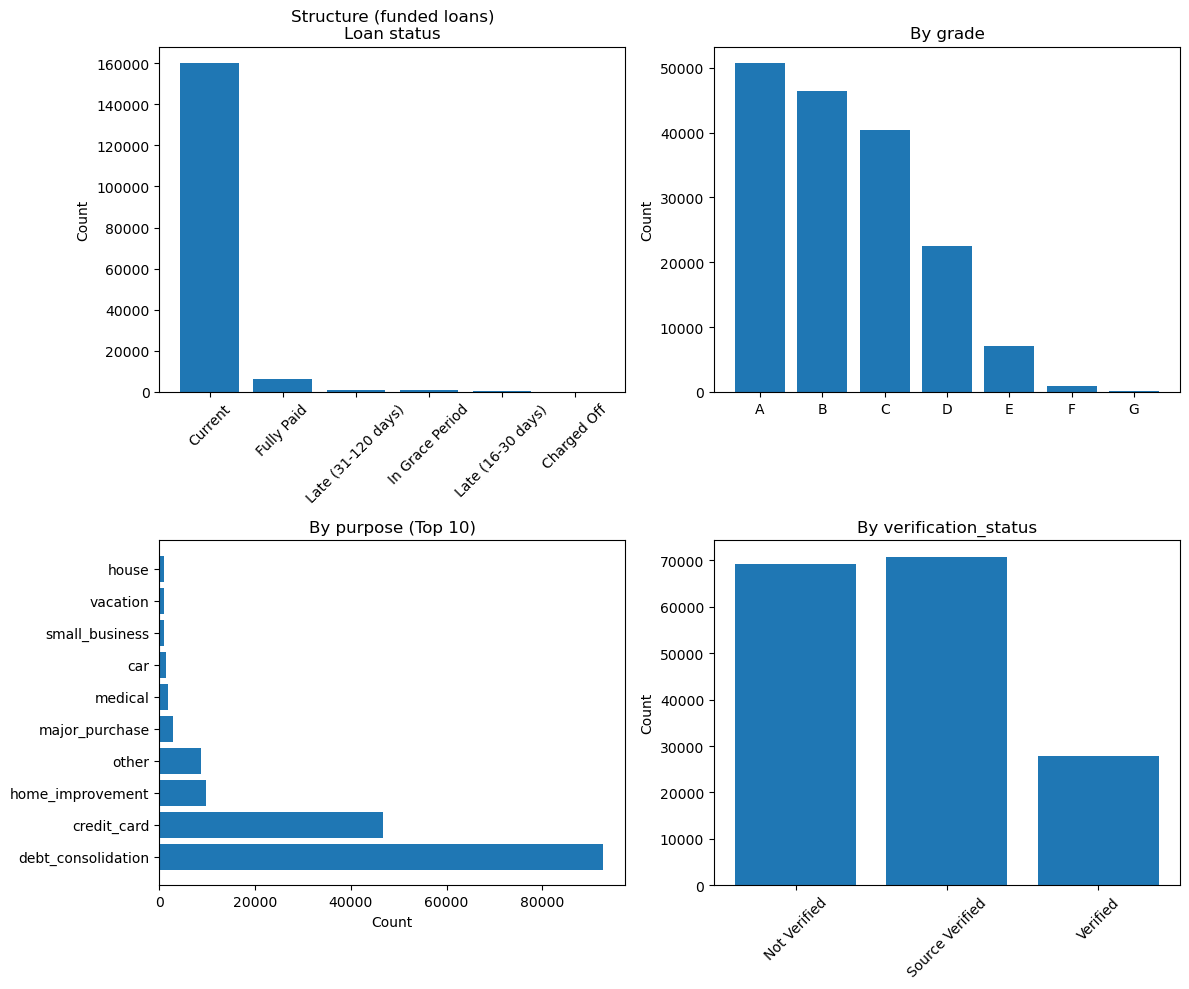

In [28]:
# By grade / By purpose (Top 10) / By verification_status / Structure (funded loans) — 整合为一张图（4 个直方图）
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 左上：Loan status (Structure - funded loans)
v = df["loan_status"].value_counts()
axes[0, 0].bar(range(len(v)), v.values, tick_label=v.index)
axes[0, 0].tick_params(axis="x", rotation=45)
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Structure (funded loans)\nLoan status")

# 右上：By grade
if by_grade is not None and len(by_grade) > 0:
    axes[0, 1].bar(by_grade["grade"], by_grade["Count"]) #by_grade是按grade分组后的数据，是dataframe，所以by_grade["grade"]是grade的值，by_grade["Count"]是grade的计数
    axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("By grade")

# 左下：By purpose (Top 10)
axes[1, 0].barh(range(len(by_purpose)), by_purpose["Count"], tick_label=by_purpose["purpose"])
axes[1, 0].set_xlabel("Count")
axes[1, 0].set_title("By purpose (Top 10)")

# 右下：By verification_status
if by_ver is not None and len(by_ver) > 0:
    axes[1, 1].bar(by_ver["verification_status"], by_ver["Count"])
    axes[1, 1].tick_params(axis="x", rotation=45)
    axes[1, 1].set_ylabel("Count")
axes[1, 1].set_title("By verification_status")

plt.tight_layout()
plt.show()

### 第二部分：违约分析

违约率按以下维度展示：信用等级、利率分箱、DTI 分箱、循环使用率分箱、近两年逾期次数、破产记录。图表与表格标签为英文。

In [7]:
if "grade" in df.columns:
    gr = df.groupby("grade", as_index=False).agg(
        cnt=("is_default", "count"),
        defaults=("is_default", "sum"),
    )
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    gr = gr.sort_values("grade")
    display(gr)

,grade,cnt,defaults,default_rate
0,A,50701,203,0.004004
1,B,46403,384,0.008275
2,C,40330,589,0.014605
3,D,22433,524,0.023358
4,E,7077,209,0.029532
5,F,856,53,0.061916
6,G,181,13,0.071823


In [8]:
if "int_rate" in df.columns:
    df["int_rate_bin"] = pd.cut(
        pd.to_numeric(df["int_rate"].astype(str).str.replace("%", "", regex=False), errors="coerce"),
        bins=[0, 10, 15, 20, 100],
        labels=["0-10%", "10-15%", "15-20%", "20%+"],
    )
    gr = df.groupby("int_rate_bin", as_index=False, observed=True).agg(
        cnt=("is_default", "count"),
        defaults=("is_default", "sum"),
    )
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    display(gr)

,int_rate_bin,cnt,defaults,default_rate
0,0-10%,50719,204,0.004022
1,10-15%,63412,590,0.009304
2,15-20%,38775,711,0.018337
3,20%+,15075,470,0.031177


In [9]:
if "dti" in df.columns:
    dti_num = pd.to_numeric(df["dti"], errors="coerce")
    df["dti_bin"] = pd.cut(dti_num, bins=[0, 10, 20, 30, 100], labels=["0-10", "10-20", "20-30", "30+"])
    gr = df.groupby("dti_bin", as_index=False, observed=True).agg(
        cnt=("is_default", "count"),
        defaults=("is_default", "sum"),
    )
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    display(gr)

,dti_bin,cnt,defaults,default_rate
0,0-10,30389,380,0.012505
1,10-20,66694,710,0.010646
2,20-30,48570,552,0.011365
3,30+,21995,323,0.014685


In [10]:
if "revol_util" in df.columns:
    rv = pd.to_numeric(df["revol_util"].astype(str).str.replace("%", "", regex=False), errors="coerce")
    df["revol_util_bin"] = pd.cut(rv, bins=[0, 30, 50, 80, 100], labels=["0-30%", "30-50%", "50-80%", ">80%"])
    gr = df.groupby("revol_util_bin", as_index=False, observed=True).agg(
        cnt=("is_default", "count"),
        defaults=("is_default", "sum"),
    )
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    display(gr)

,revol_util_bin,cnt,defaults,default_rate
0,0-30%,52018,573,0.011015
1,30-50%,47188,505,0.010702
2,50-80%,51402,635,0.012354
3,>80%,15911,230,0.014455


In [11]:
if "delinq_2yrs" in df.columns:
    gr = df.groupby("delinq_2yrs", as_index=False).agg(
        cnt=("is_default", "count"),
        defaults=("is_default", "sum"),
    )
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    gr = gr.sort_values("delinq_2yrs")
    display(gr)

,delinq_2yrs,cnt,defaults,default_rate
0,0,143361,1583,0.011042
1,1,17368,275,0.015834
2,2,4335,69,0.015917
3,3,1486,31,0.020861
4,4,662,13,0.019637
5,5,307,3,0.009772
6,6,177,1,0.005650
7,7,94,0,0.000000
8,8,52,0,0.000000
9,9,41,0,0.000000


In [12]:
col = "pub_rec_bankruptcies"
if col not in df.columns:
    col = "pub_rec"
if col in df.columns:
    gr = df.groupby(col, as_index=False).agg(
        cnt=("is_default", "count"),
        defaults=("is_default", "sum"),
    )
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    gr = gr.sort_values(col)
    display(gr)
else:
    print("Column pub_rec_bankruptcies / pub_rec not found, skipped.")

,pub_rec_bankruptcies,cnt,defaults,default_rate
0,0,148656,1727,0.011617
1,1,19113,246,0.012871
2,2,184,2,0.010870
3,3,21,0,0.000000
4,4,5,0,0.000000
5,5,1,0,0.000000
6,6,1,0,0.000000


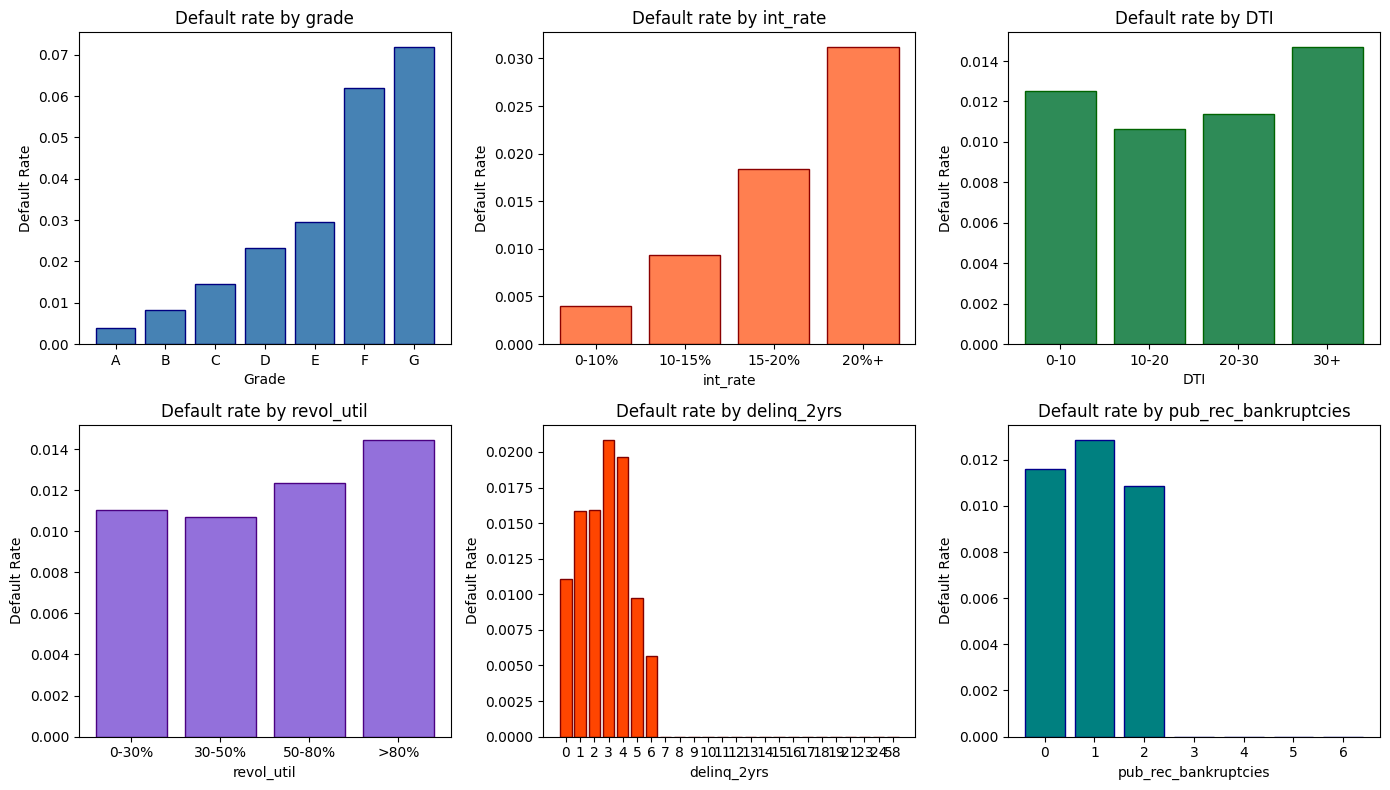

In [13]:
# Default rate by xxx — 整合到一张图 (2x3 子图)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

if "grade" in df.columns:
    gr = df.groupby("grade", as_index=False).agg(cnt=("is_default", "count"), defaults=("is_default", "sum"))
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    gr = gr.sort_values("grade")
    axes[0].bar(gr["grade"], gr["default_rate"], color="steelblue", edgecolor="navy")
    axes[0].set_xlabel("Grade")
    axes[0].set_ylabel("Default Rate")
    axes[0].set_title("Default rate by grade")
else:
    axes[0].set_visible(False)

if "int_rate" in df.columns:
    df_plot = df.copy()
    df_plot["int_rate_bin"] = pd.cut(
        pd.to_numeric(df_plot["int_rate"].astype(str).str.replace("%", "", regex=False), errors="coerce"),
        bins=[0, 10, 15, 20, 100], labels=["0-10%", "10-15%", "15-20%", "20%+"])
    gr = df_plot.groupby("int_rate_bin", as_index=False, observed=True).agg(cnt=("is_default", "count"), defaults=("is_default", "sum"))
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    axes[1].bar(range(len(gr)), gr["default_rate"], tick_label=gr["int_rate_bin"], color="coral", edgecolor="darkred")
    axes[1].set_xlabel("int_rate")
    axes[1].set_ylabel("Default Rate")
    axes[1].set_title("Default rate by int_rate")
else:
    axes[1].set_visible(False)

if "dti" in df.columns:
    dti_num = pd.to_numeric(df["dti"], errors="coerce")
    df_plot = df.assign(dti_bin=pd.cut(dti_num, bins=[0, 10, 20, 30, 100], labels=["0-10", "10-20", "20-30", "30+"]))
    gr = df_plot.groupby("dti_bin", as_index=False, observed=True).agg(cnt=("is_default", "count"), defaults=("is_default", "sum"))
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    axes[2].bar(range(len(gr)), gr["default_rate"], tick_label=gr["dti_bin"], color="seagreen", edgecolor="darkgreen")
    axes[2].set_xlabel("DTI")
    axes[2].set_ylabel("Default Rate")
    axes[2].set_title("Default rate by DTI")
else:
    axes[2].set_visible(False)

if "revol_util" in df.columns:
    rv = pd.to_numeric(df["revol_util"].astype(str).str.replace("%", "", regex=False), errors="coerce")
    df_plot = df.assign(revol_util_bin=pd.cut(rv, bins=[0, 30, 50, 80, 100], labels=["0-30%", "30-50%", "50-80%", ">80%"]))
    gr = df_plot.groupby("revol_util_bin", as_index=False, observed=True).agg(cnt=("is_default", "count"), defaults=("is_default", "sum"))
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    axes[3].bar(range(len(gr)), gr["default_rate"], tick_label=gr["revol_util_bin"], color="mediumpurple", edgecolor="indigo")
    axes[3].set_xlabel("revol_util")
    axes[3].set_ylabel("Default Rate")
    axes[3].set_title("Default rate by revol_util")
else:
    axes[3].set_visible(False)

if "delinq_2yrs" in df.columns:
    gr = df.groupby("delinq_2yrs", as_index=False).agg(cnt=("is_default", "count"), defaults=("is_default", "sum"))
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    gr = gr.sort_values("delinq_2yrs")
    axes[4].bar(gr["delinq_2yrs"].astype(str), gr["default_rate"], color="orangered", edgecolor="maroon")
    axes[4].set_xlabel("delinq_2yrs")
    axes[4].set_ylabel("Default Rate")
    axes[4].set_title("Default rate by delinq_2yrs")
else:
    axes[4].set_visible(False)

col = "pub_rec_bankruptcies"
if col not in df.columns:
    col = "pub_rec"
if col in df.columns:
    gr = df.groupby(col, as_index=False).agg(cnt=("is_default", "count"), defaults=("is_default", "sum"))
    gr["default_rate"] = gr["defaults"] / gr["cnt"]
    gr = gr.sort_values(col)
    axes[5].bar(gr[col].astype(str), gr["default_rate"], color="teal", edgecolor="darkblue")
    axes[5].set_xlabel(col)
    axes[5].set_ylabel("Default Rate")
    axes[5].set_title("Default rate by pub_rec_bankruptcies")
else:
    axes[5].set_visible(False)

plt.tight_layout()
plt.show()

**违约率表与整合图总结（风险部分）**  
- **Grade**：等级越差违约率越高（A 约 0.4% → G 约 7.2%），与结构表一致。  
- **int_rate 分箱**：利率越高违约率越高（0–10% 约 0.4%，20%+ 约 3.1%），存在风险与定价联动。  
- **DTI 分箱**：高 DTI（如 30+）违约率更高，建议对高负债比客群收紧或重定价。  
- **revol_util 分箱**：循环使用率越高违约率越高，>80% 需重点关注。  
- **delinq_2yrs / pub_rec**：无明显结论 
- **结论**：多维度交叉验证了风险与定价、客群特征的一致性，可支撑准入、额度与定价策略。